In [1]:
import string
import math
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter, ScalarFormatter, NullFormatter, FixedLocator
from sklearn.metrics import roc_curve

from gauss_mix import generate_gauss_mix

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
sns.set(color_codes=True, style="ticks", context="talk", font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

In [6]:
# Constants
COL_TITLES = [
    "S@98",
    "AUC",
    "Mutual Information",
    "Power"
]
# yellow and #999999 are left
COMMON_CLFS = {
    "MIGHT" : {"color" : "#e41a1c", "lw" : 3},
    "RF" : {"color" : "#377eb8"},
    "SVM" : {"color" : "#4daf4a"},
    "LR" : {"color" : "#ff7f00"},
    "KNN" : {"color" : "#a65628"},
}
NROWS = 2
NCOLS = len(COL_TITLES)
SUBPLOT_LABELS = [
    "Ai)",
    "Aii)",
    "Bi)",
    "Bii)",
    "Biii)",
    "Di)",
    "Ci)",
    "Cii)",
    "Ciii)",
    "Dii)",
]

def plot_might(simulation_name):
    # Error check
    correct_sims = ["nonlinear", "linear", "independent"]
    if simulation_name not in correct_sims:
        raise ValueError(f"Simulation name must be in {correct_sims}")

    # Create a figure
    fig = plt.figure(figsize=(30, 12), constrained_layout=True)
    gs = fig.add_gridspec(1, 2, width_ratios=[1 / (NCOLS + 2), 1 - 1 / (NCOLS + 2)], wspace=0.5)
    
    # SIMULATION
    gs_left = gs[0].subgridspec(3, 1, height_ratios=[0.25, 0.25, 0.5], hspace=0.1)
    ax0 = fig.add_subplot(gs_left[0])
    ax1 = fig.add_subplot(gs_left[1])
    
    # generate data
    N = 50000
    SAMPLE = 256
    if simulation_name == "nonlinear":
        x, y, posterior, statistics, pdf = generate_gauss_mix(
            split_class1=(0.75, 0.25),
        )
    elif simulation_name == "linear":
        x, y, posterior, statistics, pdf = generate_gauss_mix(
            split_class1=None,
        )
    else:
        x, y, posterior, statistics, pdf = generate_gauss_mix(
            split_class0=(0.75, 0.25),
            split_class1=(0.75, 0.25),
        )
    
    # downsample the data to plot the histograms to 256 points each
    x_ = x[::N // SAMPLE]
    y_ = y[::N // SAMPLE]
    x_0, x_1 = x_[y_ == 0], x_[y_ == 1]
    
    # plot simulated data
    ax0.hist(x_0[:N // 2], density=True, color="#969696", alpha=0.5, bins=10)
    ax1.hist(x_1[:N // 2], density=True, color="#969696", alpha=0.5, bins=16)
    sns.lineplot(
        pdf, x="x", y="pdf_class0", color="black", ax=ax0
    )
    sns.lineplot(
        pdf,
        x="x",
        y="pdf_class1",
        color="black",
        ax=ax1,
    )
    
    # make plot look pretty
    ax0.set(
        title="Histogram",
        xlabel="",
        ylabel="Control\nFrequency",
        xticks=[-3, 0, 3, 6],
        yticks=[]
    )
    ax0.legend().remove()
    ax0.xaxis.set_major_formatter(NullFormatter())
    ax1.set(
        title="",
        xlabel="Variable Magnitude",
        ylabel="Case\nFrequency",
        xticks=[-3, 0, 3, 6],
        yticks=[]
    )
    ax1.legend().remove()
    
    # ROC
    ax2 = fig.add_subplot(gs_left[2])
    
    # compute true fpr, tpr, and thresholds and plot the ROC
    true_fpr, true_tpr, true_thresholds = roc_curve(
        y, posterior, pos_label=1, drop_intermediate=False
    )
    ax2.plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.5),
    ax2.plot(true_fpr, true_tpr, label="Truth", color="black")
    
    # load all other classifier ROC data and plot ROC curves
    base_fpr = np.linspace(0, 1, 1001)
    for clf_name, plot_kwargs in COMMON_CLFS.items():
        try:
            with open(f"fig1_v2_results/fpr_{simulation_name}_{clf_name}.pkl", "rb") as f:
                clf_fpr = pickle.load(f)
        except FileNotFoundError:
            print(f"fig1_v2_results/fpr_{simulation_name}_{clf_name}.pkl is missing")
            continue
        try:
            with open(f"fig1_v2_results/tpr_{simulation_name}_{clf_name}.pkl", "rb") as f:
                clf_tpr = pickle.load(f)
        except FileNotFoundError:
            print(f"fig1_v2_results/tpr_{simulation_name}_{clf_name}.pkl is missing")
            continue
        n_iterations = 100 if clf_name != "MIGHT" and simulation_name == "nonlinear" else 10 # TODO: Run everything at 100
        clf_tprs = [np.interp(base_fpr, clf_fpr[i], clf_tpr[i]) for i in range(n_iterations)]
        mean_clf_tpr = np.mean(clf_tprs, axis=0)
        ax2.plot(base_fpr, mean_clf_tpr, **plot_kwargs, label=clf_name)
    
    # make plot look pretty
    ax2.set(
        title="ROC Curve for 256 Samples and 4096 Variables",
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        xticks=[0, 1],
        yticks=[0, 1]
    )
    
    # METRICS
    gs_right = gs[1].subgridspec(NROWS, NCOLS, hspace=0.1)
    axes = [fig.add_subplot(gs_right[row, col]) for row in range(NROWS) for col in range(NCOLS)]
    
    # definte some constants
    if simulation_name == "nonlinear":
        TRUTHS = {
            "S@98" : 0.26,
            "AUC": 0.63,
            "Mutual Information": 0.09,
        }
    elif simulation_name == "linear":
        TRUTHS = {
            "S@98" : 0.14,
            "AUC": 0.76,
            "Mutual Information": 0.11,
        }
    else:
        TRUTHS = {
            "S@98" : 0.02,
            "AUC": 0.5,
            "Mutual Information": 0,
        }
    ALL_CLFS = {
        "S@98" : COMMON_CLFS,
        "Mutual Information" : dict(COMMON_CLFS, KSG={"color" : "#f781bf"}),
        "AUC" : COMMON_CLFS,
        "Power" : dict(COMMON_CLFS, Dcorr={"color" : "#984ea3"}, Dcorr_PCA={"color" : "#984ea3", "linestyle" : "--"})
    }
    FILE_METRICS = {
        "S@98": "S98",
        "Mutual Information" : "MI",
        "AUC" : "AUC",
        "Power" : "power"
    }
    
    # plot lines
    for i, ax in enumerate(axes):
        c = i % NCOLS
        metric = COL_TITLES[c]
        if metric == "Power":
            ax.axhline(
                y=0.05,
                linestyle=":",
                color="black",
                label="Alpha",
            )
        else:
            ax.axhline(
                y=TRUTHS[metric],
                color="black",
            )
    
        if i // NCOLS == 0 and metric == "Power":
            xs = [64, 128, 256, 512, 1024]
            n_or_d = "n"
        elif i // NCOLS == 0:
            xs = [256, 512, 1024, 2048, 4096]
            n_or_d = "n"
        else:
            xs = [2**i for i in range(2, 13)]
            n_or_d = "d"
        for test, plot_kwargs in ALL_CLFS[metric].items():
            file_test = test if test != "MIGHT" else test.lower()
            if metric == "Power" and test == "MIGHT":
                file_test += "-MI"
            try:
                ys = np.genfromtxt(
                    f"results/{simulation_name}-{file_test}-{FILE_METRICS[metric]}-vs-{n_or_d}.csv", delimiter=","
                )
            except FileNotFoundError:
                print(f"results/{simulation_name}-{file_test}-{FILE_METRICS[metric]}-vs-{n_or_d}.csv is missing")
                continue
            if metric == "Power":
                ys = np.array([y if y > 0 else 0 for y in ys])
                ys = ys[:5] if n_or_d == "n" else ys
                ax.plot(xs, ys, **plot_kwargs, label=test)
            else:
                quantiles = []
                for quantile in [0.25, 0.5, 0.75]:
                    quartile = np.quantile(ys, quantile, axis=1)
                    quartile = np.array([y if y > 0 else 0 for y in quartile])
                    if test == "MIGHT" and n_or_d == "n":
                        quartile = quartile[2:]
                    quantiles.append(quartile)
                ax.plot(xs, quantiles[1], **plot_kwargs, label=test)
                ax.fill_between(
                    xs,
                    quantiles[0],
                    quantiles[2],
                    alpha=0.2,
                    color=plot_kwargs["color"],
                )
    
        # make plot pretty
        ax.set(
            xscale="log" if metric == "Power" and n_or_d == "n" else "linear",
            xlabel = (
                "Sample Size" if i // NCOLS == 0
                else "# of Variables"
            ),
            ylim=(
                [-0.002, 1.01] if metric == "Power" or (simulation_name == "independent" and metric == "AUC")
                else [-0.002, 0.1] if simulation_name == "independent" and metric != "AUC"
                else [0.498, (TRUTHS[metric] - 0.5) / 0.13 * 0.05 + TRUTHS[metric]] if metric == "AUC"
                else [-0.002, 1.4 * TRUTHS[metric]]
            ),
            yticks=(
                [0, 1] if metric == "Power"
                else [0, 0.5, 1] if simulation_name == "independent" and metric == "AUC"
                else [0, TRUTHS[metric], 0.1] if simulation_name == "independent"
                else [0.5, TRUTHS[metric]] if metric == "AUC"
                else [0, TRUTHS[metric]]
            ),
            ylabel=(
                "Power" if metric == "Power" and n_or_d == "d"
                else "Power" if metric == "Power" and n_or_d == "n"
                else f"{metric}"
            )
        )
        ax.xaxis.set_minor_locator(FixedLocator(xs))
        ax.xaxis.set_major_locator(FixedLocator(
            [64, 256, 1024] if metric == "Power" and n_or_d == "n"
            else [256, 2048, 4096] if metric != "Power" and n_or_d == "n"
            else [4, 2048, 4096]
        ))
        ax.xaxis.set_major_formatter(ScalarFormatter())
        ax.xaxis.set_minor_formatter(NullFormatter())
    
    # set column titles
    for ax, label in zip([ax0, ax2] + axes, SUBPLOT_LABELS):
        ax.set_title(label, loc='left')
    axes[2].set_title("Statistical Estimates for 4096 Variables", x=0, y=1.2)
    axes[5].set_title("Statistical Estimates for 4096 Samples", x=0.5, y=1.2)
    axes[7].set_title("256 Samples", x=0.5, y=1.2)
    
    # remove spines from all subplots
    for ax in axes + [ax0, ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # add legend
    handles, labels = ax2.get_legend_handles_labels()
    handles_ksg, labels_ksg = axes[2].get_legend_handles_labels()
    handles_power, labels_power = axes[3].get_legend_handles_labels()
    legend_dict = dict(handles=handles + handles_ksg + handles_power, labels=labels + labels_ksg + labels_power)
    legend_dict = {}
    for handle, label in zip(handles + handles_ksg + handles_power, labels + labels_ksg + labels_power):
        if label == "Dcorr_PCA":
            label = "Dcorr-PCA"
        legend_dict[label] = handle
    legend_metric_dict = {key : legend_dict[key] for key in legend_dict.keys() if key not in ["Alpha", "Dcorr", "Dcorr-PCA", "KSG"]}
    legend_mi_dict = {"KSG" : legend_dict["KSG"]}
    legend_power_dict = {key : legend_dict[key] for key in legend_dict.keys() if key in ["Alpha", "Dcorr", "Dcorr-PCA"]}
    leg = fig.legend(
        handles=legend_metric_dict.values(),
        labels=legend_metric_dict.keys(),
        loc="lower center",
        ncol=len(legend_dict),
        bbox_to_anchor=(0.3, -0.12)
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)
    
    leg1 = fig.legend(
        handles=legend_mi_dict.values(),
        labels=legend_mi_dict.keys(),
        loc="lower center",
        ncol=2,
        bbox_to_anchor=(0.7, -0.12)
    )
    leg1.get_frame().set_linewidth(0.0)
    for legobj in leg1.legend_handles:
        legobj.set_linewidth(5.0)
    
    leg2 = fig.legend(
        handles=legend_power_dict.values(),
        labels=legend_power_dict.keys(),
        loc="lower center",
        ncol=2,
        bbox_to_anchor=(0.9, -0.167)
    )
    leg2.get_frame().set_linewidth(0.0)
    for legobj in leg2.legend_handles:
        legobj.set_linewidth(5.0)
    
    plt.show()

results/nonlinear-RF-S98-vs-n.csv is missing
results/nonlinear-RF-AUC-vs-n.csv is missing
results/nonlinear-RF-MI-vs-n.csv is missing
results/nonlinear-RF-power-vs-n.csv is missing
results/nonlinear-SVM-power-vs-n.csv is missing
results/nonlinear-LR-power-vs-n.csv is missing
results/nonlinear-KNN-power-vs-n.csv is missing
results/nonlinear-RF-S98-vs-d.csv is missing
results/nonlinear-RF-AUC-vs-d.csv is missing
results/nonlinear-RF-MI-vs-d.csv is missing
results/nonlinear-RF-power-vs-d.csv is missing
results/nonlinear-SVM-power-vs-d.csv is missing
results/nonlinear-LR-power-vs-d.csv is missing
results/nonlinear-KNN-power-vs-d.csv is missing


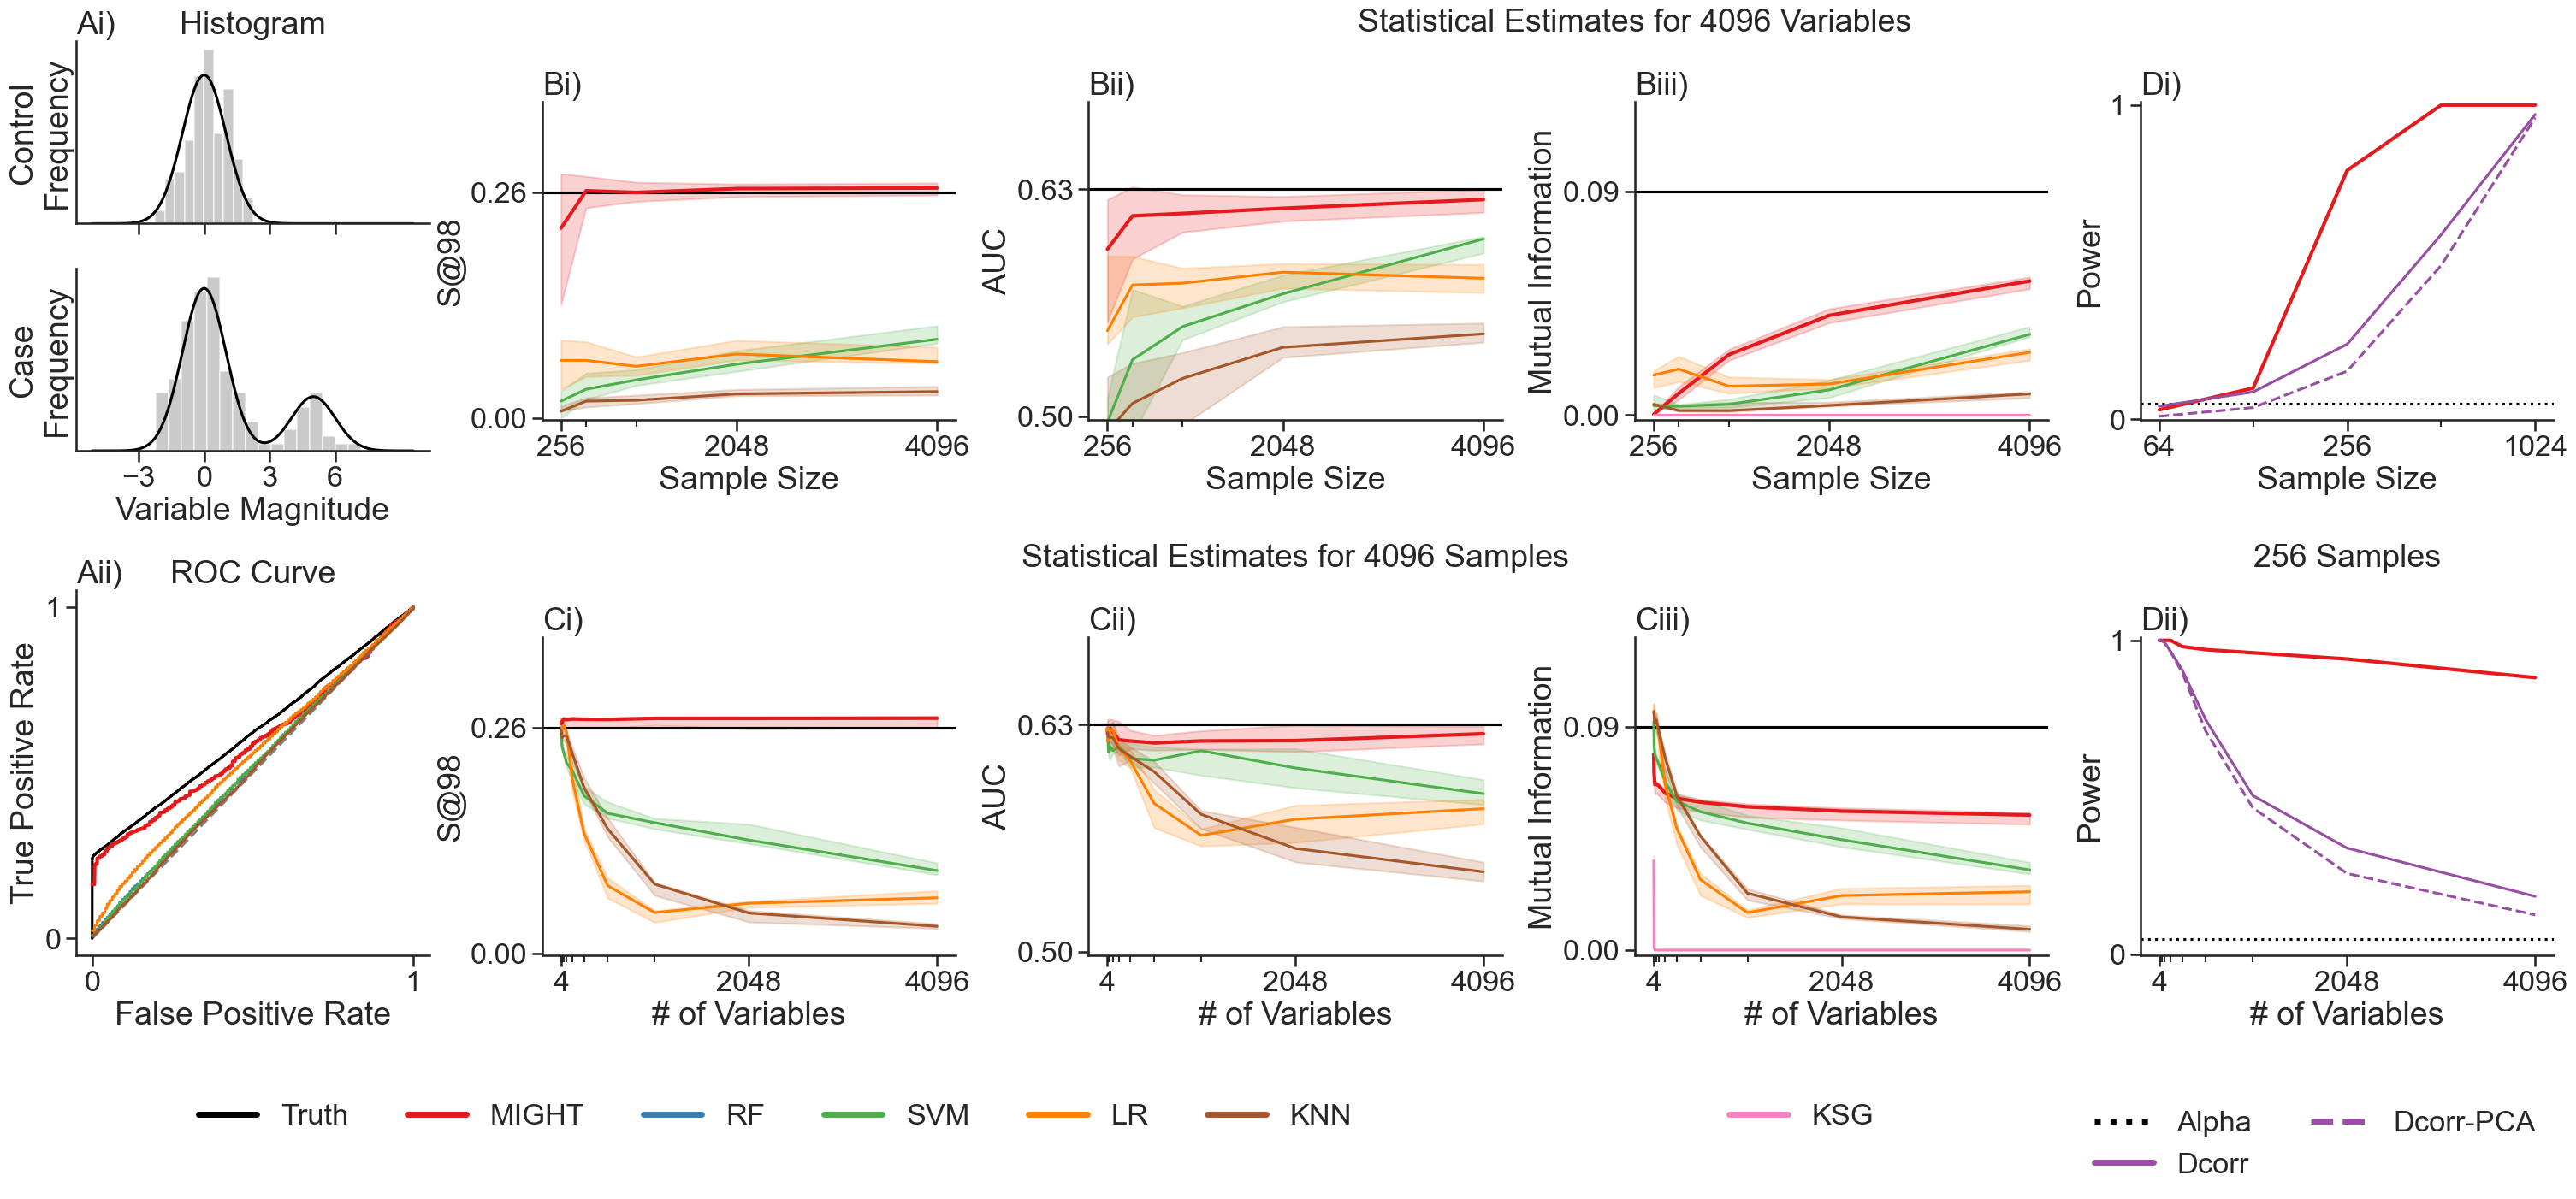

In [5]:
plot_might(simulation_name="nonlinear")

fig1_v2_results/fpr_linear_RF.pkl is missing
results/linear-RF-S98-vs-n.csv is missing
results/linear-RF-AUC-vs-n.csv is missing
results/linear-RF-MI-vs-n.csv is missing
results/linear-RF-power-vs-n.csv is missing
results/linear-SVM-power-vs-n.csv is missing
results/linear-LR-power-vs-n.csv is missing
results/linear-KNN-power-vs-n.csv is missing
results/linear-RF-S98-vs-d.csv is missing
results/linear-RF-AUC-vs-d.csv is missing
results/linear-RF-MI-vs-d.csv is missing
results/linear-RF-power-vs-d.csv is missing
results/linear-SVM-power-vs-d.csv is missing
results/linear-LR-power-vs-d.csv is missing
results/linear-KNN-power-vs-d.csv is missing


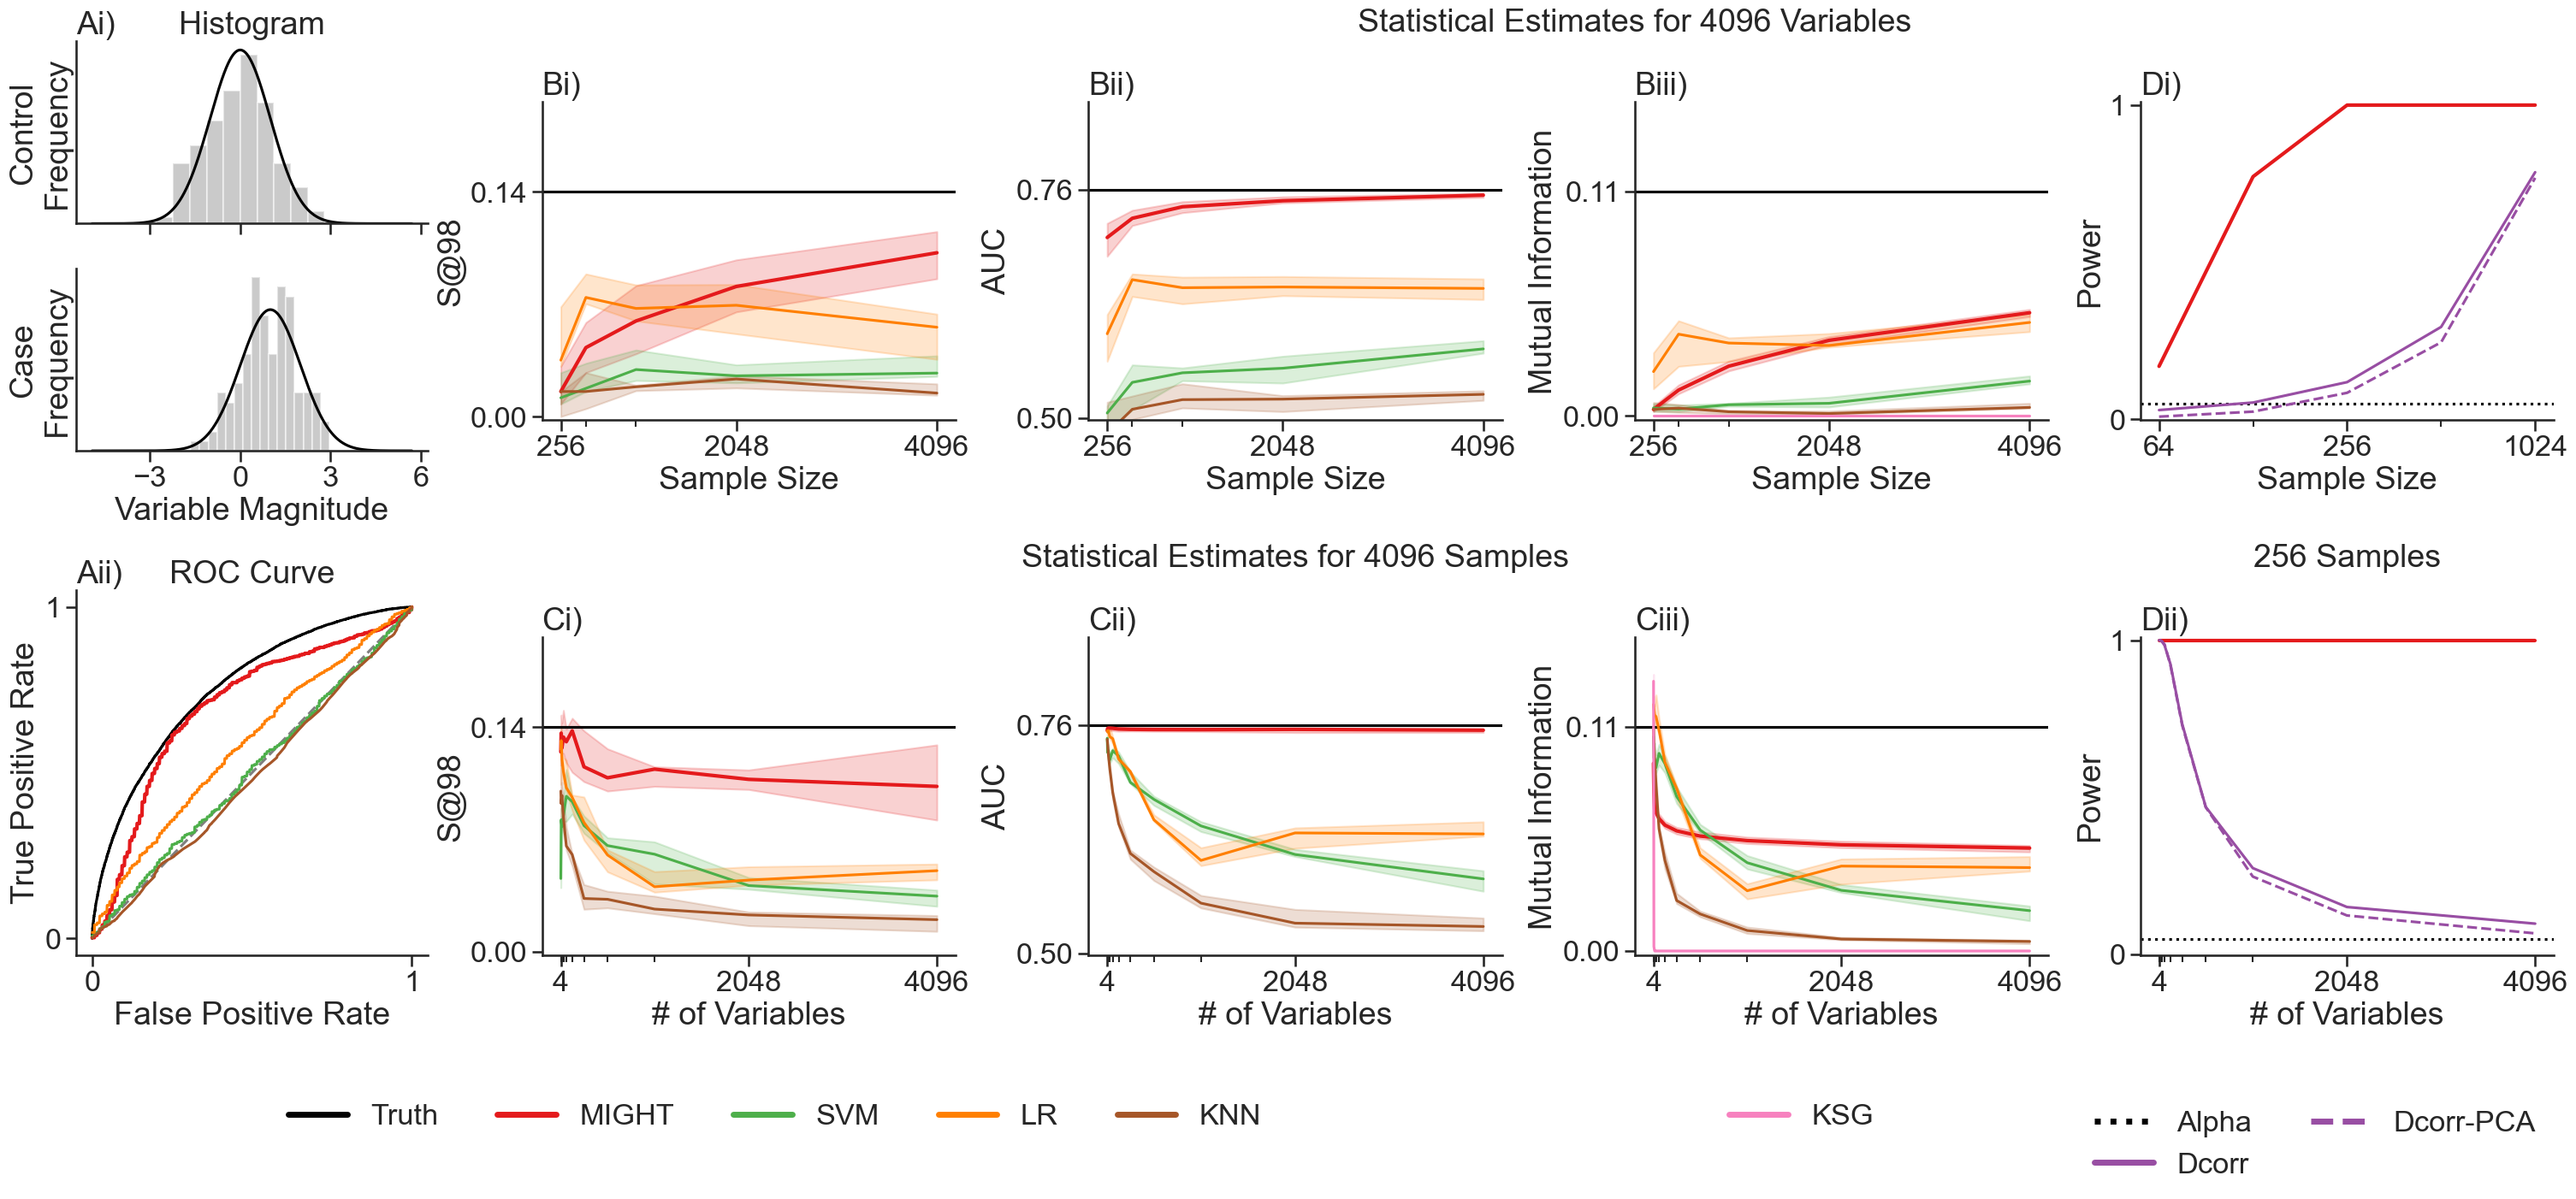

In [6]:
plot_might(simulation_name="linear")

fig1_v2_results/fpr_independent_RF.pkl is missing
results/independent-RF-S98-vs-n.csv is missing
results/independent-RF-AUC-vs-n.csv is missing
results/independent-RF-MI-vs-n.csv is missing
results/independent-RF-power-vs-n.csv is missing
results/independent-SVM-power-vs-n.csv is missing
results/independent-LR-power-vs-n.csv is missing
results/independent-KNN-power-vs-n.csv is missing
results/independent-RF-S98-vs-d.csv is missing
results/independent-RF-AUC-vs-d.csv is missing
results/independent-RF-MI-vs-d.csv is missing
results/independent-RF-power-vs-d.csv is missing
results/independent-SVM-power-vs-d.csv is missing
results/independent-LR-power-vs-d.csv is missing
results/independent-KNN-power-vs-d.csv is missing


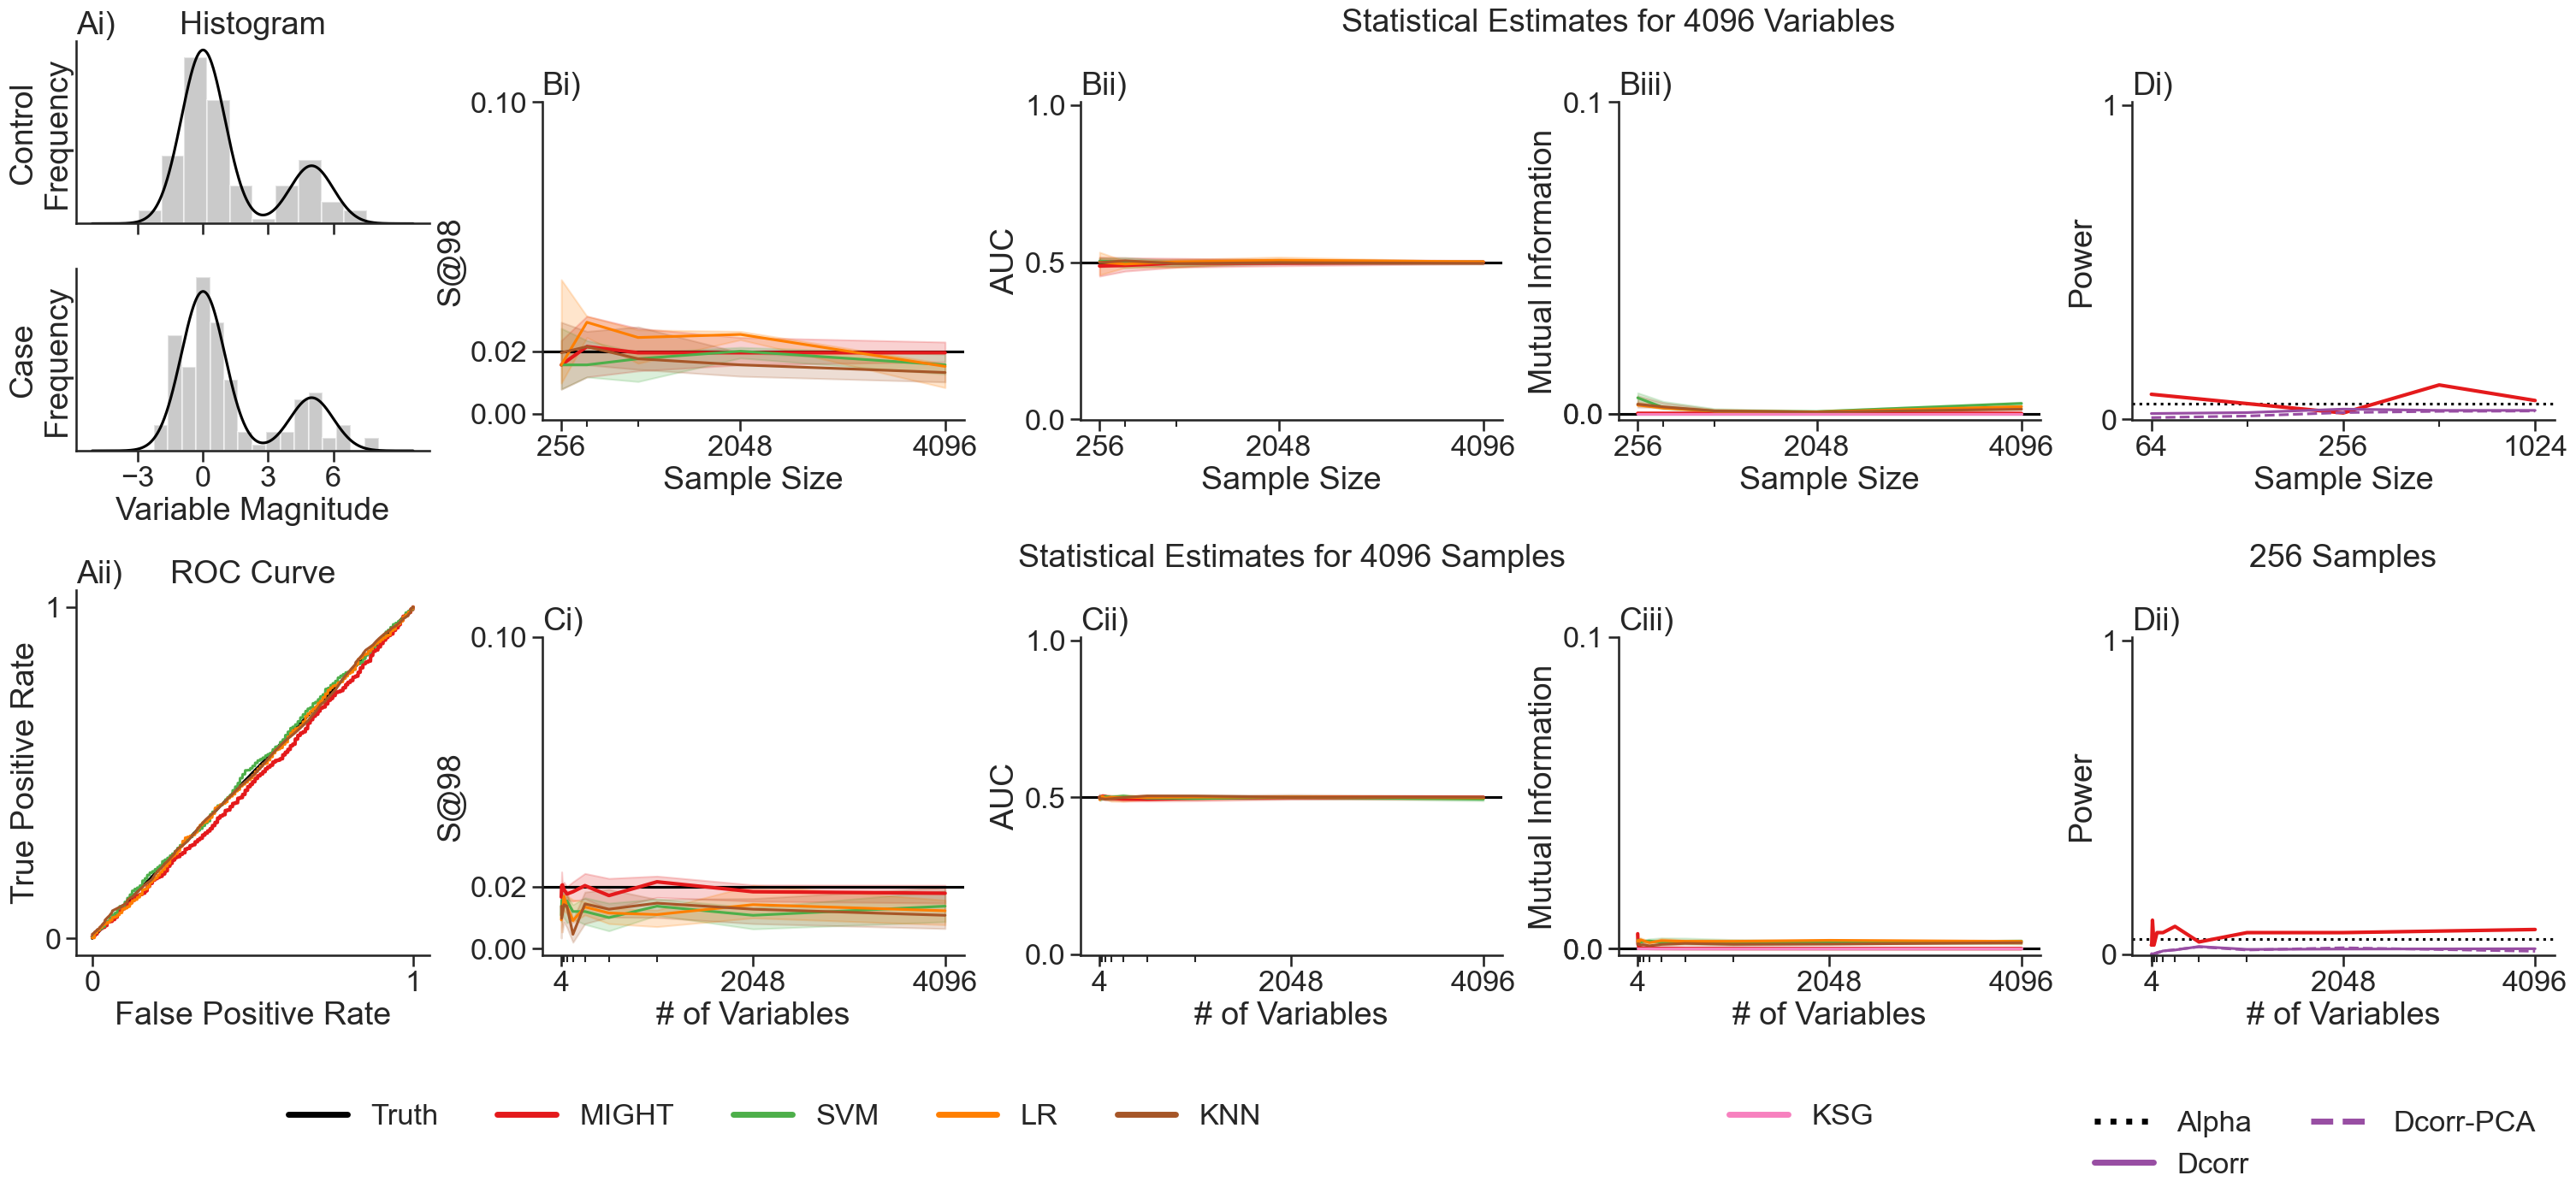

In [7]:
plot_might(simulation_name="independent")

# Old Figures

## Non-Conditional

In [23]:
sns.set_theme(color_codes=True, style='ticks', context='talk', font_scale=1.5)

NROWS, NCOLS = 3, 3
DIM_SIZES = [2**i for i in range(2, 13)]
DATA_PATH = "results"
FIG_PATH = "figs"

SIMULATIONS = [
    "linear",
    "nonlinear",
    "independent",
]

S98_KWARGS = {
    "SVM" : {"color" : "#ff7f00", "label" : "SVM"},
    "LR" : {"color" : "#984ea3", "label" : "LR"},
    # "KNN_PCA" : {"color" : "#377eb8", "label" : "KNN PCA", "linestyle" : "--"},
    "KNN" : {"color" : "#377eb8", "lw" : 3, "label" : "KNN"},
    # "RF" : {"color" : "#377eb8", "label" : "RF"},
    "drf" : {"color" : "#f781bf", "lw" : 3, "label" : "DRF"},
    "might" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT"},
#     "altermight" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT Alter", "linestyle" : "--"},
    "Truth" : {
        "linear" : 0.14,
        "nonlinear" : 0.26,
        "independent": 0.02
    }
}

MI_KWARGS = {
    # "KSG_PCA" : {"color" : "#4daf4a", "label" : "KSG PCA", "linestyle" : "--"},
    "KSG" : {"color" : "#4daf4a", "lw" : 3, "label" : "KSG"},
    "SVM" : {"color" : "#ff7f00", "label" : "SVM"},
    "LR" : {"color" : "#984ea3", "label" : "LR"},
    "KNN" : {"color" : "#377eb8", "lw" : 3, "label" : "KNN"},
    "drf" : {"color" : "#f781bf", "lw" : 3, "label" : "DRF"},
    "might" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT"},
#     "altermight" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT Alter", "linestyle" : "--"},
    "Truth" : {
        "linear" : 0.11,
        "nonlinear" : 0.09,
        "independent": 0.00
    }
}

POWER_KWARGS = {
    "Dcorr_PCA" : {"color" : "#a65628", "lw" : 3, "label" : "Dcorr PCA"},
    "Dcorr" : {"color" : "#ff7f00", "lw" : 3, "label" : "Dcorr"},
    "hypoRF" : {"color" : "#984ea3", "lw" : 3, "label" : "hypoRF"},
    # "might-Acc" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT Acc", "linestyle" : "-."},
    # "might-AUC" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT AUC", "linestyle" : "--"},
    # "might-MI" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT MI", "linestyle" : ":"},
    # "might-S98" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT S@98"},
    "might-MI" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT"},
    "Alpha" : {
        "linear" : 0.05,
        "nonlinear" : 0.05,
        "independent": 0.05
    }
}

HD_KWARGS = {
    "drf" : {"color" : "#f781bf", "lw" : 3, "label" : "DRF"},
    "SVM" : {"color" : "#ff7f00", "label" : "SVM"},
    "LR" : {"color" : "#984ea3", "label" : "LR"},
    "KNN" : {"color" : "#377eb8", "lw" : 3, "label" : "KNN"},
    "might" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT"},
    "Truth" : {
        "linear" : 0.24,
        "nonlinear" : 0.25,
        "independent": 0.00
    }
}

AUC_KWARGS = {
    "SVM" : {"color" : "#ff7f00", "label" : "SVM"},
    "LR" : {"color" : "#984ea3", "label" : "LR"},
    # "KNN_PCA" : {"color" : "#377eb8", "label" : "KNN PCA", "linestyle" : "--"},
    "KNN" : {"color" : "#377eb8", "lw" : 3, "label" : "KNN"},
    # "RF" : {"color" : "#377eb8", "label" : "RF"},
    "drf" : {"color" : "#f781bf", "lw" : 3, "label" : "DRF"},
    "might" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT"},
#     "altermight" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT Alter", "linestyle" : "--"},
    "Truth" : {
        "linear" : 0.76,
        "nonlinear" : 0.63,
        "independent": 0.50
    }
}

STAT_KWARGS = {
    "AUC" : {"kwargs" : AUC_KWARGS, "title" : "AUC"},
    "S98" : {"kwargs" : S98_KWARGS, "title" : "S@98"},
    "MI" : {"kwargs" : MI_KWARGS, "title" : "Mutual Information"},
#     "hd" : {"kwargs" : HD_KWARGS, "title" : "Distribution Distance"},
}

### Data Refactor

In [6]:
# Refactor Data
SIMS = {"linear": "trunk", "nonlinear": "trunk_mix", "independent": "trunk_overlap"}
ALPHA = 0.05

MAX_REPS = {
    "drf": 10,
    "KSG": 10,
    "KSG_PCA": 10,
    "KNN_PCA": 100,
    "Dcorr": 1000,
    "Dcorr_PCA": 1000,
    "hypoRF": 1000,
}


def refactor_data_s98(data, alg="SVMrbf", type="n"):
    for sim, file_sim in SIMS.items():
        if alg == "KNN_PCA":
            vs = "samp" if type == "n" else "dim" if type == "d" else ""
            dfs = [
                pd.read_csv(
                    f"{data}/{SIMS[sim]}_s98_knnpca_{vs}_rep{rep}.csv",
                    sep=",",
                    header=None,
                )
                for rep in range(MAX_REPS[alg])
            ]
            refactored_data = pd.concat(dfs, axis=1)
            np.savetxt(
                f"{DATA_PATH}/{sim}-{alg}-S98-vs-{type}.csv",
                refactored_data,
                delimiter=",",
            )
        else:
            df = pd.read_csv(data)
            grouped = df.groupby(df.simulation)
            sim_df = grouped.get_group(SIMS[sim])
            grouped = df.groupby(sim_df.model)
            alg_df = grouped.get_group(alg)
            alg_df["n_sample"] = alg_df["n_sample"].astype(int)
            alg_df["n_dim"] = alg_df["n_dim"].astype(int)
            if type == "n":
                vs_sampsize = alg_df[alg_df["n_dim"] == 4096]
                N = vs_sampsize.n_sample.value_counts(sort=False).min()
                N = N - N % len(SAMPLE_SIZES)
                refactored_data = (
                    vs_sampsize.sample(frac=1)
                    .groupby("n_sample", sort=False)
                    .head(N)["s@98"]
                    .to_numpy()
                    .reshape(len(SAMPLE_SIZES), -1)
                )
            elif type == "d":
                vs_dim = alg_df[alg_df["n_sample"] == 4096]
                N = vs_dim.n_dim.value_counts(sort=False).min()
                N = N - N % len(DIM_SIZES)
                refactored_data = (
                    vs_dim.sample(frac=1)
                    .groupby("n_dim", sort=False)
                    .head(N)["s@98"]
                    .to_numpy()
                    .reshape(len(DIM_SIZES), -1)
                )
        np.savetxt(
            f"{DATA_PATH}/{sim}-{alg}-S98-vs-{type}.csv", refactored_data, delimiter=","
        )


def refactor_data_mi(data, alg="KSG", sim="linear", type="n"):
    file_alg = "ksgpca_" if alg == "KSG_PCA" else ""
    vs = "samp" if type == "n" else "dim" if type == "d" else ""
    dfs = [
        pd.read_csv(
            f"{data}/{SIMS[sim]}_mi_{file_alg}{vs}_rep{rep}.csv", sep=",", header=None
        )
        for rep in range(MAX_REPS[alg])
    ]
    df = pd.concat(dfs, axis=1)
    np.savetxt(
        f"{DATA_PATH}/{sim}-{alg}-MI-vs-{type}.csv", df.to_numpy(), delimiter=","
    )


def refactor_data_power(alg="Dcorr", sim="linear", type="n"):
    power = []
    if type == "n":
        file_path = f"p-4096_n-256_4096/{sim}_{alg}"
        for samp_size in SAMPLE_SIZES:
            if alg == "hypoRF":
                alt_dist, null_dist = map(
                    np.float64,
                    zip(
                        *[
                            np.genfromtxt(f"{file_path}_{samp_size}_{rep}.txt")
                            for rep in range(MAX_REPS[alg])
                        ]
                    ),
                )
                cutoff = np.sort(1 - null_dist)[math.ceil(MAX_REPS[alg] * (1 - ALPHA))]
                empirical_power = (1 + ((1 - alt_dist) >= cutoff).sum()) / (
                    1 + MAX_REPS[alg]
                )
            else:
                pvals = np.array(
                    [
                        np.genfromtxt(f"{file_path}_{samp_size}_{rep}.txt")
                        for rep in range(MAX_REPS[alg])
                    ]
                )
                empirical_power = (1 + (pvals <= ALPHA).sum()) / (1 + MAX_REPS[alg])
            power.append(empirical_power)
    elif type == "d":
        file_path = f"n-256_p-4_4096/{sim}_{alg}"
        for dim in DIM_SIZES:
            if alg == "hypoRF":
                alt_dist, null_dist = map(
                    np.float64,
                    zip(
                        *[
                            np.genfromtxt(f"{file_path}_{dim}_{rep}.txt")
                            for rep in range(MAX_REPS[alg])
                        ]
                    ),
                )
                cutoff = np.sort(1 - null_dist)[math.ceil(MAX_REPS[alg] * (1 - ALPHA))]
                empirical_power = (1 + ((1 - alt_dist) >= cutoff).sum()) / (
                    1 + MAX_REPS[alg]
                )
            else:
                pvals = np.array(
                    [
                        np.genfromtxt(f"{file_path}_{dim}_{rep}.txt")
                        for rep in range(MAX_REPS[alg])
                    ]
                )
                empirical_power = (1 + (pvals <= ALPHA).sum()) / (1 + MAX_REPS[alg])
            power.append(empirical_power)
    np.savetxt(f"{DATA_PATH}/{sim}-{alg}-power-vs-{type}.csv", power, delimiter=",")


def refactor_data_hd(data=None, alg="might", sim="linear", type="n"):
    if alg == "might":
        hd = np.genfromtxt(f"raw_results/{sim}-{alg}-hd-vs-{type}.csv", delimiter=",")
        if type == "n":
            for i, samp_size in enumerate(SAMPLE_SIZES):
                hd[i, :] = hd[i, :] / np.sqrt(samp_size)
        elif type == "d":
            for i, dim in enumerate(DIM_SIZES):
                hd[i, :] = hd[i, :] / np.sqrt(4096)
    elif alg == "drf":
        if type == "n":
            dfs = [
                pd.read_csv(
                    f"{data}/{SIMS[sim]}_helldistance_samp_rep{rep}.csv",
                    sep=",",
                    header=None,
                )
                for rep in range(MAX_REPS[alg])
            ]
            df = pd.concat(dfs, axis=1)
        elif type == "d":
            dfs = [
                pd.read_csv(
                    f"{data}/{SIMS[sim]}_helldistance_dim_rep{rep}.csv",
                    sep=",",
                    header=None,
                )
                for rep in range(MAX_REPS[alg])
            ]
            df = pd.concat(dfs, axis=1)
        hd = df.to_numpy()
    np.savetxt(f"{DATA_PATH}/{sim}-{alg}-hd-vs-{type}.csv", hd, delimiter=",")

In [7]:
for type in ["n"]:#, "d"]:
    # for alg in ["SVMrbf", "LRliblinear", "KNN", "RF"]:
    for alg in ["KNN", "KNN_PCA"]:
        data = "raw_results/result_knn" if alg == "KNN_PCA" else "raw_results/s98_results_.csv"
        refactor_data_s98(data=data, alg=alg, type=type)

NameError: name 'SAMPLE_SIZES' is not defined

In [ ]:
for sim in SIMS.keys():
    for type in ["n"]:#, "d"]:
        for alg in ["KSG", "KSG_PCA"]:
            refactor_data_mi(data="raw_results/result_ksg", type=type, sim=sim)

In [ ]:
for sim in ["linear", "nonlinear", "independent"]:
    for type in ["n", "d"]:
        for alg in ["Dcorr", "Dcorr_PCA", "hypoRF"]:
            refactor_data_power(alg=alg, type=type, sim=sim)

In [ ]:
for sim in ["linear", "nonlinear", "independent"]:
    for type in ["n", "d"]:
        for alg in ["might", "drf"]:
            refactor_data_hd(data="raw_results/result_drf", alg=alg, type=type, sim=sim)

### Plot Figures

In [24]:
def plot_stats(plot_type="vs-n", fig_name="figure-2"):
    fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(16, 14))

    lines = []
    for r, row in enumerate(ax):
        for c, col in enumerate(row):
            sim = SIMULATIONS[c]
            stat = list(STAT_KWARGS.keys())[r]
            stat_kwargs = STAT_KWARGS[stat]["kwargs"]
            col.axhline(
                y=stat_kwargs["Truth"][sim],
                linestyle=":",
                color="#000000",
                label="Truth",
            )

            for test, plot_kwargs in stat_kwargs.items():
                if plot_type == "vs-n":
                    xs = [2**i for i in range(8, 13)]
                    try:
                        ys = np.genfromtxt(
                            f"{DATA_PATH}/{sim}-{test}-{stat}-vs-n.csv", delimiter=","
                        )
                    except FileNotFoundError:
                        continue
                elif plot_type == "vs-d":
                    xs = DIM_SIZES
                    try:
                        ys = np.genfromtxt(
                            f"{DATA_PATH}/{sim}-{test}-{stat}-vs-d.csv", delimiter=","
                        )
                    except FileNotFoundError:
                        continue

                medians = np.quantile(ys, 0.5, axis=1)
                lower_quartile = np.quantile(ys, 0.25, axis=1)
                upper_quartile = np.quantile(ys, 0.75, axis=1)
                medians = np.array([y if y > 0 else 0 for y in medians])
                lower_quartile = np.array([y if y > 0 else 0 for y in lower_quartile])
                upper_quartile = np.array([y if y > 0 else 0 for y in upper_quartile])
                if stat == "hd":
                    continue
                if test == "might" and plot_type == "vs-n":
                    line = col.plot(xs, medians[2:], **plot_kwargs)
                    col.fill_between(
                        xs,
                        lower_quartile[2:],
                        upper_quartile[2:],
                        alpha=0.2,
                        color=plot_kwargs["color"],
                    )
#                 elif test == "drf" and stat != "AUC":
#                     line = col.plot(xs, medians[2:], **plot_kwargs)
#                     col.fill_between(
#                         xs,
#                         lower_quartile[2:],
#                         upper_quartile[2:],
#                         alpha=0.2,
#                         color=plot_kwargs["color"],
#                     )
                else:
                    line = col.plot(xs, medians, **plot_kwargs)
                    col.fill_between(
                        xs,
                        lower_quartile,
                        upper_quartile,
                        alpha=0.2,
                        color=plot_kwargs["color"],
                    )
                lines.extend(line)

            col.set(
                title=(
                    "Null" if c == 2 and r == 0 else sim.capitalize() if r == 0 else ""
                ),
                xlabel=(
                    "Sample Size"
                    if plot_type == "vs-n" and r == 2
                    else "# of Variables" if plot_type == "vs-d" and r == 2 else ""
                ),
                ylabel=(
                    f"{STAT_KWARGS[stat]['title']}\nfor 4096 Variables"
                    if plot_type == "vs-n" and c == 0
                    else (
                        f"{STAT_KWARGS[stat]['title']}\nfor 4096 Samples"
                        if plot_type == "vs-d" and c == 0
                        else ""
                    )
                ),
                yticks=(
                    [0, stat_kwargs["Truth"][sim], 0.1]
                    if c == 2 and stat != "AUC"
                    else [0, stat_kwargs["Truth"][sim]]
                ),
                ylim=(
                    # else [-0.001, 0.1] if c == 2 and stat == "S98"
                    [-0.001, 0.1]
                    if c == 2  and stat in ["MI", "S98"]
                    else [
                        -0.001,
                        stat_kwargs["Truth"][sim] + 0.4 * stat_kwargs["Truth"][sim],
                    ]
                ),
                xticks=(
                    [256, 2048, 4096]
                    if plot_type == "vs-n"
                    else [4, 2048, 4096] if plot_type == "vs-d" else ""
                ),
            )
            col.get_yaxis().set_major_formatter(StrMethodFormatter("{x:.2f}"))
            col.set_title(
                string.ascii_uppercase[r * NCOLS + c], loc="left", weight="bold"
            )
            sns.despine(right=True)
            plt.tight_layout(pad=0.2, w_pad=1.0, h_pad=1.0)

    legend_locs = [0.99, 0.66, 0.33]
    for i in range(NROWS):
        leg = ax[i, 0].legend(
            bbox_to_anchor=(1.05, legend_locs[i]),
            bbox_transform=plt.gcf().transFigure,
            ncol=1,
            loc="upper center",
            reverse=True,
        )
        leg.get_frame().set_linewidth(0.0)
        for legobj in leg.legend_handles:
            legobj.set_linewidth(5.0)

    plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches="tight")


def plot_power(fig_name="figure-4"):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

    for r, row in enumerate(ax):
        for c, col in enumerate(row):
            sim = SIMULATIONS[c]
            col.axhline(
                y=POWER_KWARGS["Alpha"][sim],
                linestyle=":",
                color="#000000",
                label="Alpha",
            )

            for test, plot_kwargs in POWER_KWARGS.items():
                if r == 0:
                    xs = [64, 128, 256, 512, 1024]
                    try:
                        ys = np.genfromtxt(
                            f"{DATA_PATH}/{sim}-{test}-power-vs-n.csv", delimiter=","
                        )
                    except FileNotFoundError:
                        continue
                elif r == 1:
                    xs = DIM_SIZES
                    try:
                        ys = np.genfromtxt(
                            f"{DATA_PATH}/{sim}-{test}-power-vs-d.csv", delimiter=","
                        )
                    except FileNotFoundError:
                        continue
                ys = np.array([y if y > 0 else 0 for y in ys])
                if r == 0:
                    col.plot(xs[:5], ys[:5], **plot_kwargs)
                else:
                    col.plot(xs, ys, **plot_kwargs)

            col.set(
                xscale="log" if r == 0 else "linear",
                title=(
                    "Null" if c == 2 and r == 0 else sim.capitalize() if r == 0 else ""
                ),
                xlabel=(
                    "Sample Size (Log Scale)"
                    if r == 0
                    else "# of Variables" if r == 1 else ""
                ),
                ylabel=(
                    f"Power\nfor 4096 Variables"
                    if r == 0 and c == 0
                    else f"Power\nfor 256 Samples" if r == 1 and c == 0 else ""
                ),
                yticks=[0, 1.0],
                ylim=[-0.01, 1.01],
                xticks=(
                    # [256, 2048, 4096] if r == 0
                    #                     [256, 1024, 2048] if r == 0
                    [64, 256, 1024]
                    if r == 0
                    else [4, 2048, 4096] if r == 1 else ""
                ),
            )
            col.xaxis.set_major_formatter(ScalarFormatter())
            col.xaxis.set_minor_formatter(NullFormatter())
            col.set_title(string.ascii_uppercase[r * 3 + c], loc="left", weight="bold")
            sns.despine(right=True)
            plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=1.0)

    leg = plt.legend(
        bbox_to_anchor=(0.5, 0.01),
        bbox_transform=plt.gcf().transFigure,
        # ncol=len(POWER_KWARGS) // 2,
        ncol=len(POWER_KWARGS),
        loc="upper center",
        reverse=True,
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)

    plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches="tight")

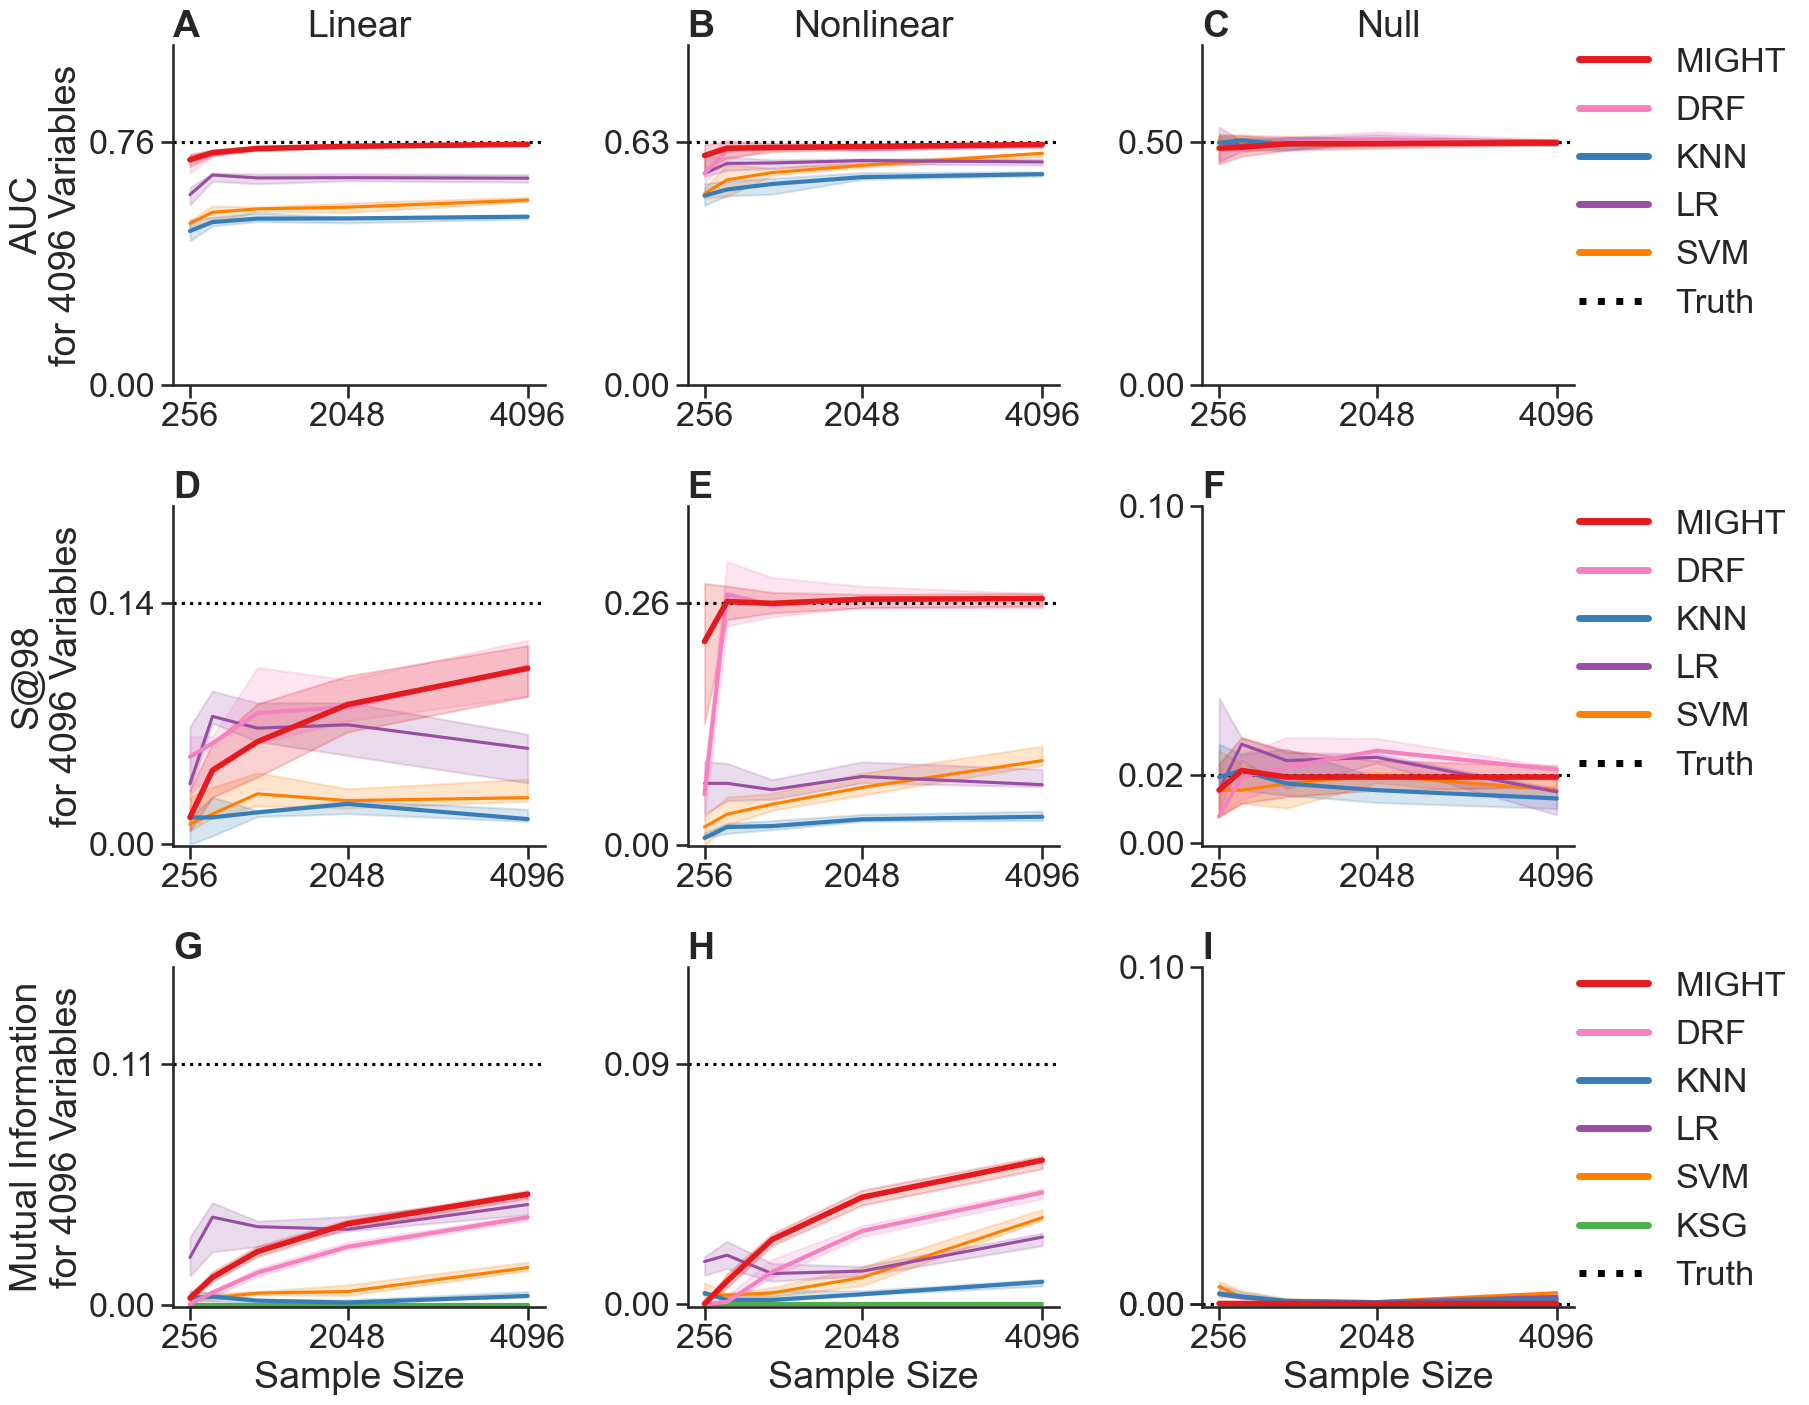

In [25]:
plot_stats(plot_type="vs-n", fig_name="figure-2")

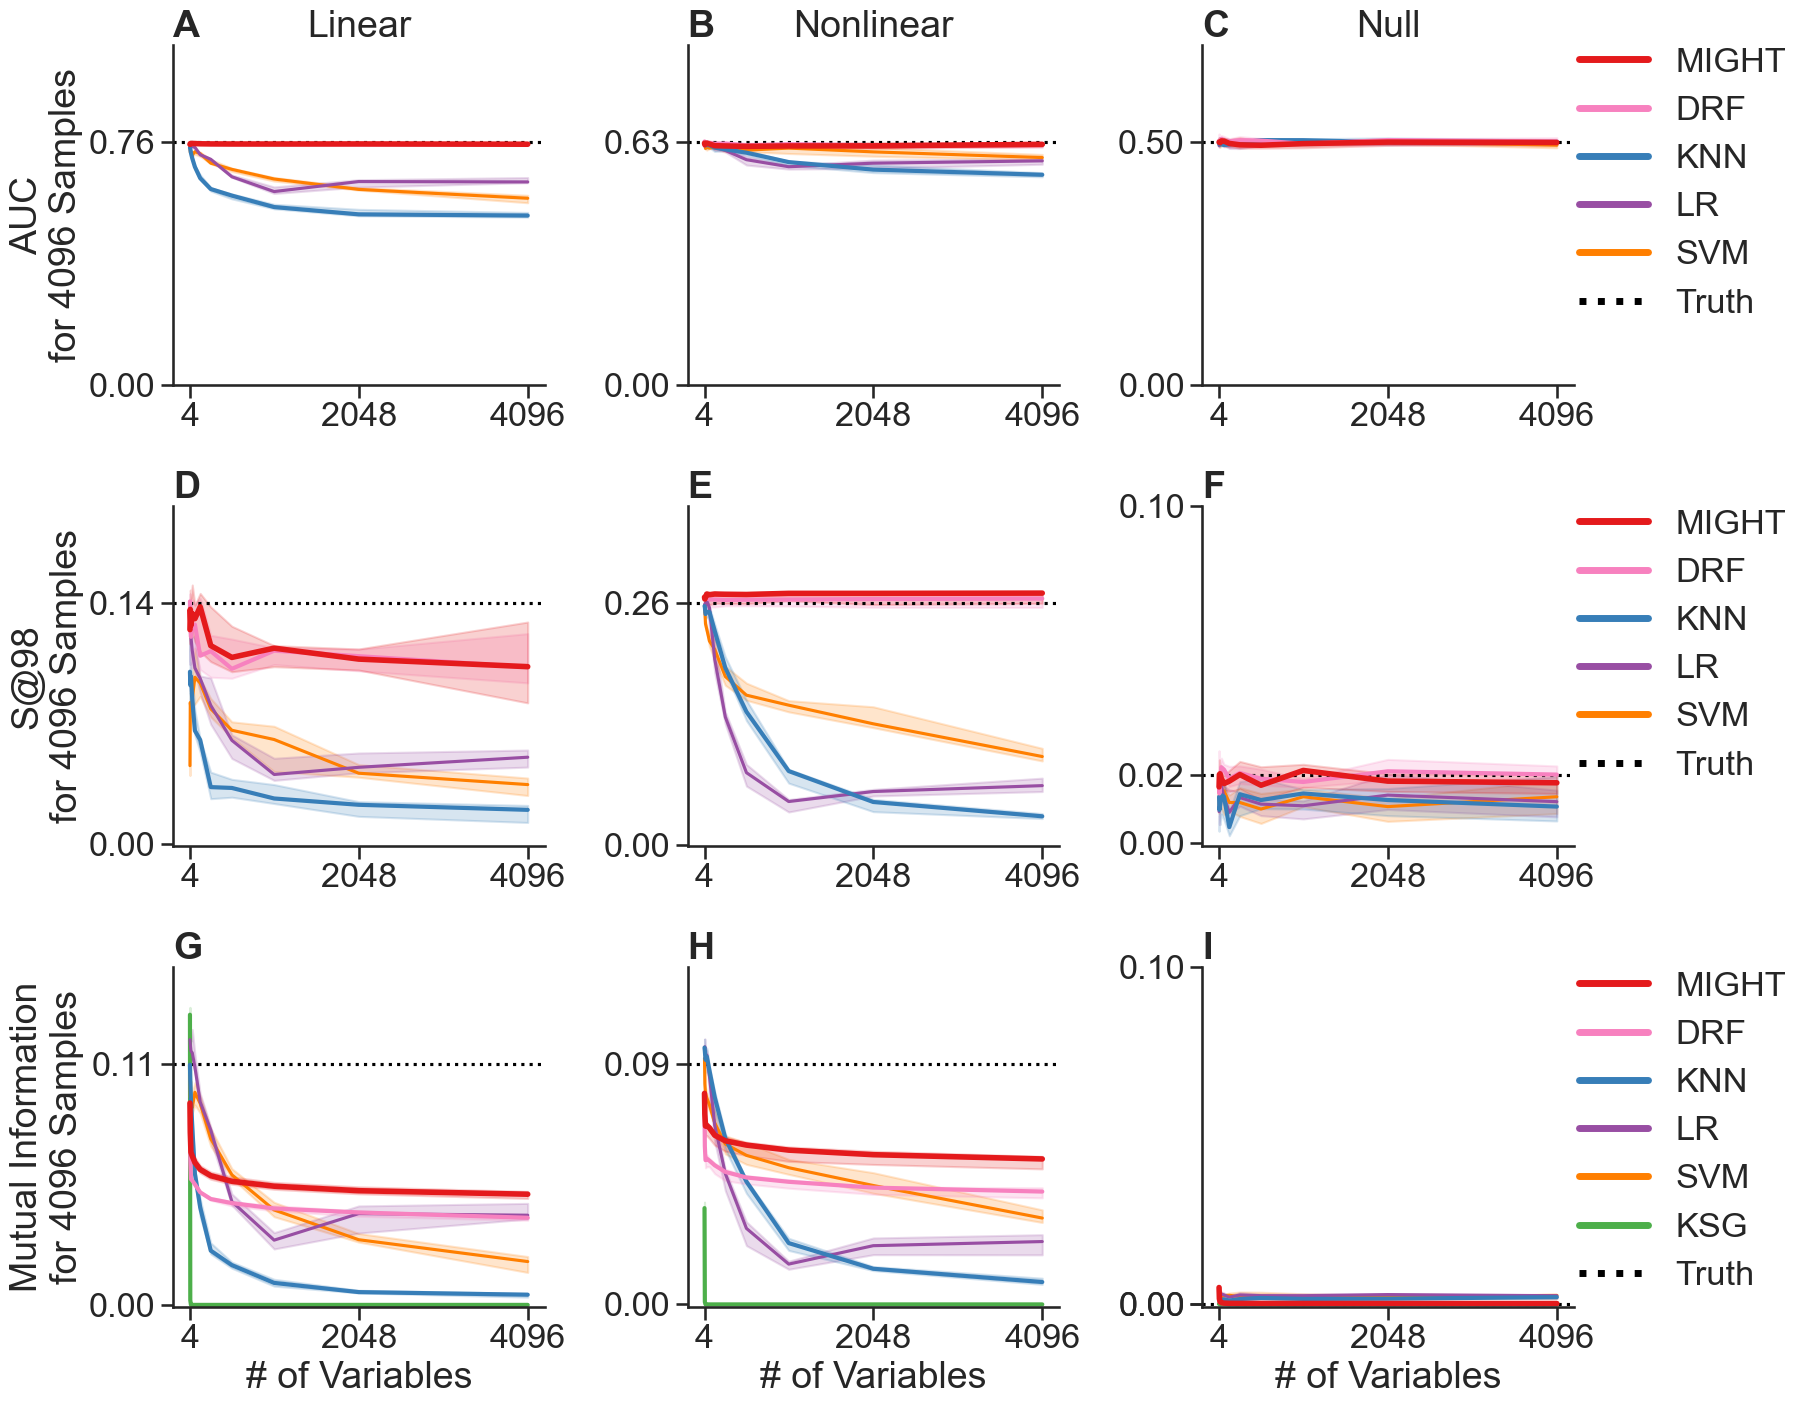

In [26]:
plot_stats(plot_type="vs-d", fig_name="figure-s2")

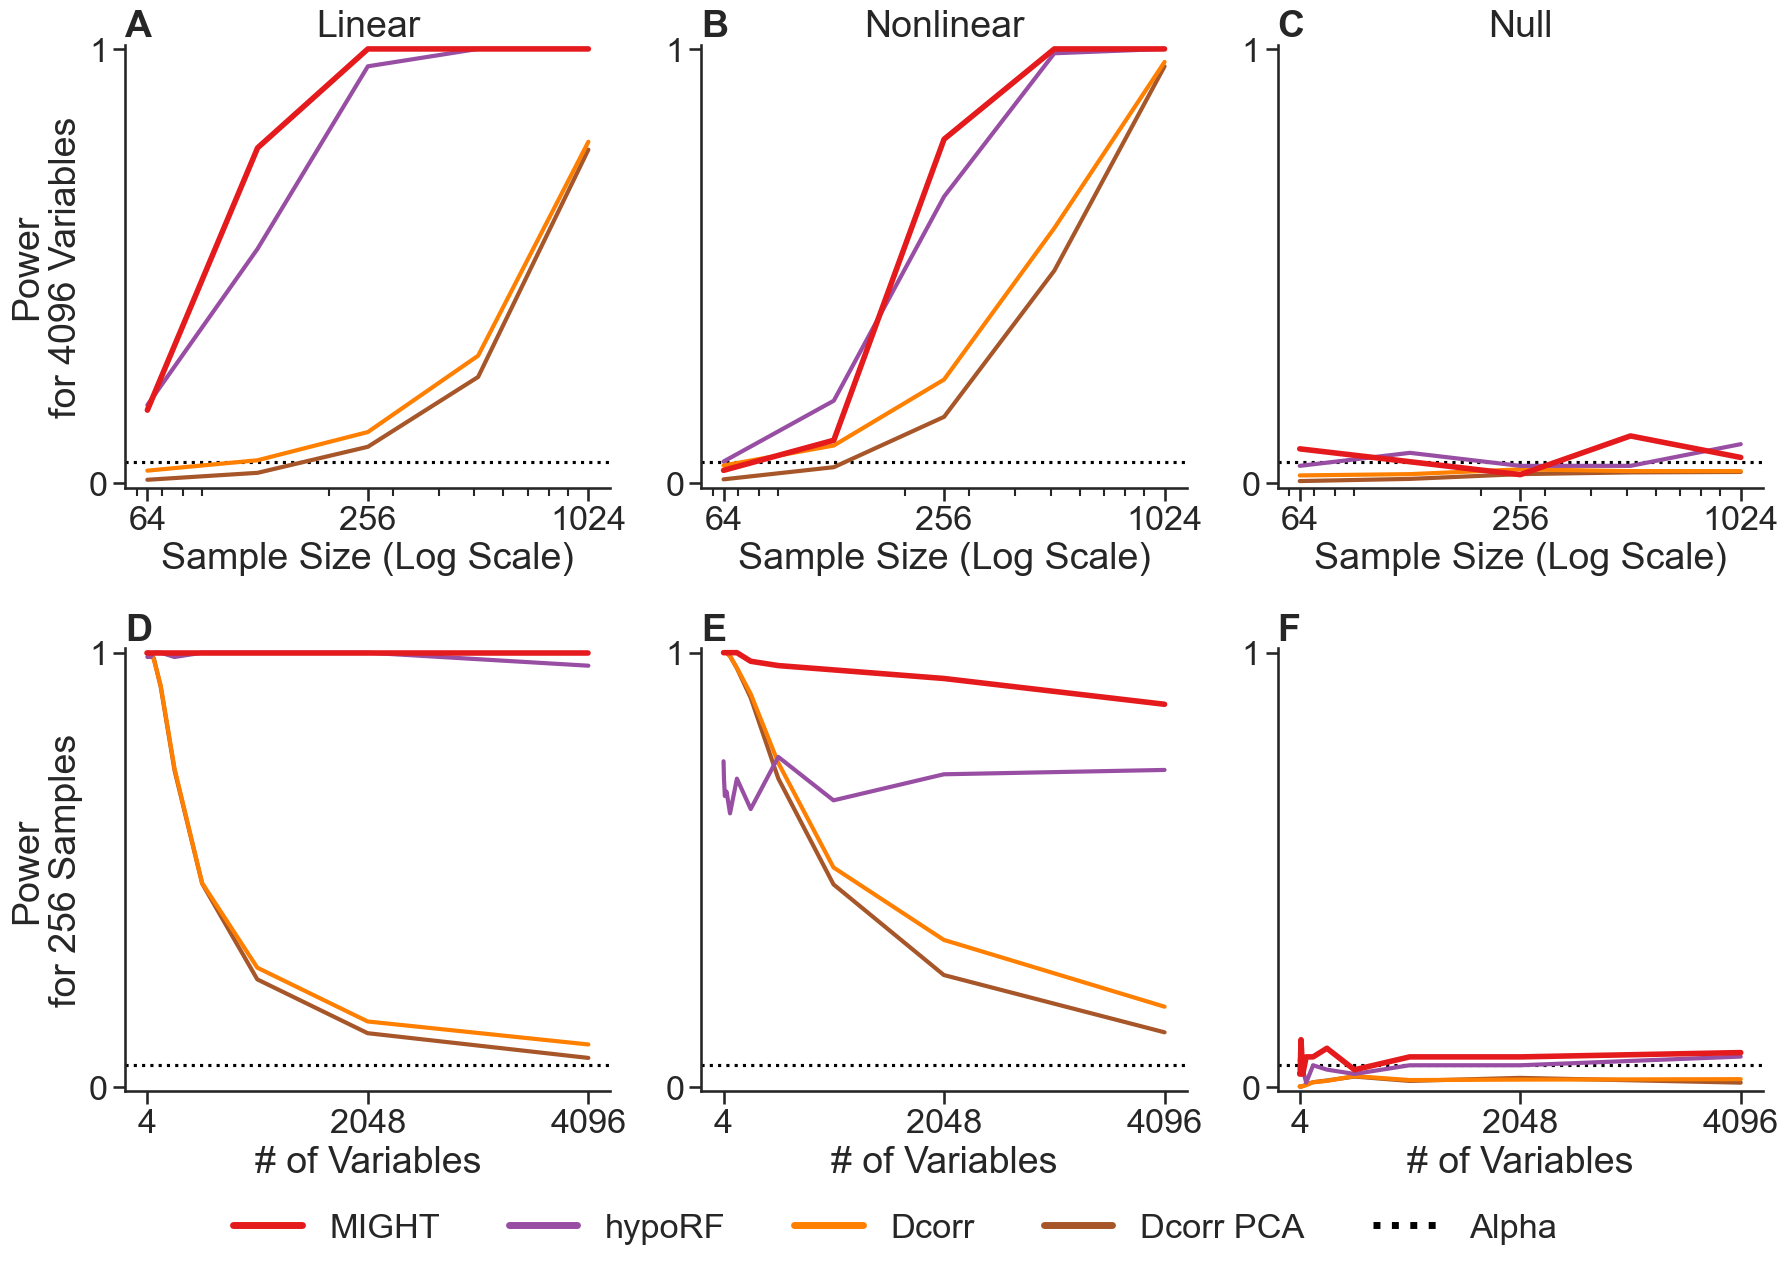

In [27]:
plot_power(fig_name="figure-4")

## Conditional

In [ ]:
CO_NROWS, CO_NCOLS = 2, 3
CO_DIM_SIZES = [2, 10, 26, 58, 122, 250, 506, 1018, 2042, 4090]

CO_SIMS = {
    "linear" : "mean_shiftv2",
    "nonlinear" : "multi_modalv2",
    "independent" : "multi_equal"
}

CO_ALGS_STATS = {
    "sas98" : ["comight", "knn", "knn_viewtwo", "knn_viewone", "might_viewone", "might_viewtwo"],
    "cmi" : ["comight", "ksg"],
}

CO_S98_KWARGS = {
    "knn_viewtwo" : {"color" : "#377eb8", "label" : "KNN View 2", "linestyle" : "-."},
    "knn_viewone" : {"color" : "#377eb8", "label" : "KNN View 1", "linestyle" : "--"},
    "knn" : {"color" : "#377eb8", "label" : "KNN"},
    "might_viewtwo" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT View 2", "linestyle" : "-."},
    "might_viewone" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT View 1", "linestyle" : "--"},
    "comight" : {"color" : "#e41a1c", "lw" : 4, "label" : "CoMIGHT"},
    "Truth" : {
        "linear" : 0.26,
        "nonlinear" : 0.28,
        "independent": 0.02
    }
}

CMI_KWARGS = {
    "ksg" : {"color" : "#4daf4a", "label" : "KSG"},
    "comight" : {"color" : "#e41a1c", "lw" : 4, "label" : "CoMIGHT"},
    "Truth" : {
        "linear" : 0.11,
        "nonlinear" : 0.15,
        "independent": 0
    }
}

CO_POWER_KWARGS = {
    # "Dcorr_PCA" : {"color" : "#ff7f00", "lw" : 2, "label" : "Dcorr PCA", "linestyle" : "--"},
    # "Dcorr" : {"color" : "#ff7f00", "lw" : 2, "label" : "Dcorr"},
    # "hypoRF" : {"color" : "#984ea3", "lw" : 2, "label" : "hypoRF"},
    # "might-Acc" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT Acc", "linestyle" : "-."},
    # "might-AUC" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT AUC", "linestyle" : "--"},
    # "might-MI" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT MI", "linestyle" : ":"},
    # "might-S98" : {"color" : "#e41a1c", "lw" : 4, "label" : "MIGHT S@98"},
    "cond_dcorr" : {"color" : "#ff7f00", "lw" : 2, "label" : "Conditional Dcorr"},
    "comight_mi" : {"color" : "#e41a1c", "lw" : 4, "label" : "CoMIGHT MI", "linestyle" : ":"},
    "comight_sas98" : {"color" : "#e41a1c", "lw" : 4, "label" : "CoMIGHT S@98"},
    "Alpha" : {
        "linear" : 0.05,
        "nonlinear" : 0.05,
        "independent": 0.05
    }
}

COMIGHT_STAT_KWARGS = {
    "cmi" : {"kwargs" : CMI_KWARGS, "title" : "Conditional Mutual Information"},
    "sas98" : {"kwargs" : CO_S98_KWARGS, "title" : "S@98"},
}

### Data Refactor

In [ ]:
TYPES = {
    "n" : {"vs" : "nsamples", "groupby" : "n_samples", "size_list" : SAMPLE_SIZES},
    "d" : {"vs" : "ndims", "groupby" : "n_dims_1", "size_list" : CO_DIM_SIZES},
}


def _get_refactored_data(df, sim="linear", stat="cmi", type_kwargs=None):
    df = df[df["sim_type"] == CO_SIMS[sim]]
    df = df[df["metric"] == stat]
    N = df[type_kwargs["groupby"]].value_counts(sort=False).min()
    refactored_data = df.sample(frac=1).groupby(type_kwargs["groupby"], sort=False).head(N)["metric_value"].to_numpy().reshape(len(type_kwargs["size_list"]), -1)
    return refactored_data, N


def refactor_data_stats(data, alg="comight", sim="linear", type="n", stat="cmi"):
    type_kwargs = TYPES[type]
    ndims = 1018 if stat == "cmi" else 4090
    df = pd.read_csv(data + f"/results_vs_{type_kwargs['vs']}_{CO_SIMS[sim]}_{alg}_{stat}_{ndims}_100.csv")
    refactored_data, _ = _get_refactored_data(df, sim=sim, stat=stat, type_kwargs=type_kwargs)
    np.savetxt(f"{DATA_PATH}/conditional/{sim}-conditional-{alg}-{stat}-vs-{type}.csv", refactored_data, delimiter=",")


def refactor_data_power(data, alg="comight", sim="linear", type="n", stat="cmi"):
    type_kwargs = TYPES[type]
    df = pd.read_csv(data + f"/results_vs_{type_kwargs['vs']}_{CO_SIMS[sim]}_{alg}_{stat}_4090_100.csv")
    df_perm = pd.read_csv(data + f"/results_vs_{type_kwargs['vs']}_{CO_SIMS[sim]}_{alg}-perm_{stat}_4090_100.csv")
    refactored_data, N = _get_refactored_data(df, sim=sim, stat=stat, type_kwargs=type_kwargs)
    refactored_data_perm, N_perm = _get_refactored_data(df_perm, sim=sim, stat=stat, type_kwargs=type_kwargs)
    power = []
    power_reps = min(N, N_perm)
    for i in range(len(type_kwargs["size_list"])):
        alt_dist, null_dist = refactored_data[i, :], refactored_data_perm[i, :]
        cutoff = np.sort(null_dist)[math.ceil(power_reps * (1 - ALPHA))]
        empirical_power = (1 + (alt_dist >= cutoff).sum()) / (1 + power_reps)
        power.append(empirical_power)
    np.savetxt(f"{DATA_PATH}/conditional/{sim}-conditional-power-{alg}-{stat}-vs-{type}.csv", power, delimiter=",")

In [ ]:
for stat, algs in CO_ALGS_STATS.items():
    for sim in CO_SIMS.keys():
        for type in ["n", "d"]:
            for alg in algs:
                try:
                    refactor_data_stats(data="raw_results/comight", alg=alg, sim=sim, type=type, stat=stat)
                except FileNotFoundError:
                    print(f"{DATA_PATH}/conditional/{sim}-conditional-{alg}-{stat}-vs-{type}.csv skipped")
                    continue

In [ ]:
# df = pd.read_csv("raw_results/comight/results_vs_nsamples_knn_sas98_4090_100.csv")
# unique_models = pd.unique(df["model"])
# grouped = df.groupby(df.model)
# for model in unique_models:
#     df_model = grouped.get_group(model)
#     df_model.to_csv(f"raw_results/comight/results_vs_nsamples_{model}_sas98_4090_100.csv")

In [ ]:
for stat in CO_POWER_KWARGS.keys():
    if stat != "Alpha":
        for sim in CO_SIMS.keys():
            for type in ["n", "d"]:
                alg, stat_split = stat.split("_")
                try:
                    refactor_data_power(data="raw_results/comight", sim=sim, type=type, stat=stat_split, alg=alg)
                except FileNotFoundError:
                    print(f"{DATA_PATH}/conditional/{sim}-conditional-power-{alg}-{stat}-vs-{type}.csv skipped")
                    continue

### Plot Figures

In [ ]:
def plot_co_stats(plot_type="vs-n", fig_name="figure-5"):
    fig, ax = plt.subplots(nrows=CO_NROWS, ncols=CO_NCOLS, figsize=(18, 12))

    lines = []
    for r, row in enumerate(ax):
        for c, col in enumerate(row):
            sim = SIMULATIONS[c]
            stat = list(COMIGHT_STAT_KWARGS.keys())[r]
            stat_kwargs = COMIGHT_STAT_KWARGS[stat]["kwargs"]
            col.axhline(y=stat_kwargs["Truth"][sim], linestyle=":", color="#000000", label="Truth")

            for test, plot_kwargs in stat_kwargs.items():
                if plot_type == "vs-n":
                    xs = SAMPLE_SIZES
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/conditional/{sim}-conditional-{test}-{stat}-vs-n.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                elif plot_type == "vs-d":
                    xs = CO_DIM_SIZES
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/conditional/{sim}-conditional-{test}-{stat}-vs-d.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                medians = np.quantile(ys, 0.5, axis=1)
                lower_quartile = np.quantile(ys, 0.25, axis=1)
                upper_quartile = np.quantile(ys, 0.75, axis=1)
                medians = np.array([y if y > 0 else 0 for y in medians])
                lower_quartile = np.array([y if y > 0 else 0 for y in lower_quartile])
                upper_quartile = np.array([y if y > 0 else 0 for y in upper_quartile])
                line = col.plot(xs, medians, **plot_kwargs)
                col.fill_between(xs, lower_quartile, upper_quartile, alpha=0.2, color=plot_kwargs["color"])
                lines.extend(line)

            col.set(
                title=(
                    "Null" if c == 2
                    else sim.capitalize() if r == 0
                    else ""
                ),
                xlabel=(
                    "Sample Size" if plot_type == "vs-n" and r == 1
                    else "# of Variables" if plot_type == "vs-d" and r == 1
                    else ""
                ),
                ylabel=(
                    f"{COMIGHT_STAT_KWARGS[stat]['title']}\nfor 1024 Variables" if plot_type == "vs-n" and c == 0 and r == 0
                    else f"{COMIGHT_STAT_KWARGS[stat]['title']}\nfor 4096 Variables" if plot_type == "vs-n" and c == 0
                    else f"{COMIGHT_STAT_KWARGS[stat]['title']}\nfor 4096 Samples" if plot_type == "vs-d" and c == 0
                    else ""
                ),
                yticks=(
                    [0, stat_kwargs["Truth"][sim], 0.1] if c == 2
                    else [0, stat_kwargs["Truth"][sim]]
                ),
                ylim=(
                    # else [-0.001, 0.1] if c == 2 and stat == "S98"
                    [-0.001, 0.1] if c == 2 #and stat in ["MI", "hd"]
                    else [-0.001, stat_kwargs["Truth"][sim] + 0.4 * stat_kwargs["Truth"][sim]]
                ),
                xticks=(
                    [256, 2048, 4096] if plot_type == "vs-n"
                    else [4, 2048, 4096] if plot_type == "vs-d"
                    else ""
                )
            )
            col.get_yaxis().set_major_formatter(StrMethodFormatter("{x:.2f}"))
            col.set_title(string.ascii_uppercase[r * CO_NCOLS + c], loc="left", weight='bold')
            sns.despine(right=True)
            plt.tight_layout(pad=0.2, w_pad=1.0, h_pad=1.0)

    legend_locs = [(1.08, 0.99), (1.1, 0.49)]
    for i in range(CO_NROWS):
        leg = ax[i, 0].legend(
            bbox_to_anchor=legend_locs[i],
            bbox_transform=plt.gcf().transFigure,
            ncol=1,
            loc="upper center",
            reverse=True
        )
        leg.get_frame().set_linewidth(0.0)
        for legobj in leg.legend_handles:
            legobj.set_linewidth(5.0)

    plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches='tight')


def plot_co_power(fig_name="figure-s4"):
    fig, ax = plt.subplots(nrows=2, ncols=CO_NCOLS, figsize=(18, 12))

    for r, row in enumerate(ax):
        for c, col in enumerate(row):
            sim = SIMULATIONS[c]
            col.axhline(y=CO_POWER_KWARGS["Alpha"][sim], linestyle=":", color="#000000", label="Alpha")

            for test, plot_kwargs in CO_POWER_KWARGS.items():
                if r == 0:
                    xs = SAMPLE_SIZES
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/conditional/{sim}-conditional-power-{test.replace('_', '-')}-vs-n.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                elif r == 1:
                    xs = CO_DIM_SIZES
                    try:
                        ys = np.genfromtxt(f"{DATA_PATH}/conditional/{sim}-conditional-power-{test.replace('_', '-')}-vs-d.csv", delimiter=',')
                    except FileNotFoundError:
                        continue
                ys = np.array([y if y > 0 else 0 for y in ys])
                col.plot(xs, ys, **plot_kwargs)

            col.set(
                # xscale="log" if r == 0 else "linear",
                title=(
                    "Null" if c == 2
                    else sim.capitalize() if r == 0
                    else ""
                ),
                xlabel=(
                    "Sample Size (Log Scale)" if r == 0
                    else "# of Variables in View 1" if r == 1
                    else ""
                ),
                ylabel=(
                    f"Power\nfor 4096 Variables" if r == 0 and c == 0
                    else f"Power\nfor 512 Samples" if r == 1 and c == 0
                    else ""
                ),
                yticks=[0, 1.0],
                ylim=[-0.01, 1.01],
                xticks=(
                    [256, 2048, 4096] if r == 0
                    else [2, 2042, 4090] if r == 1
                    else ""
                )
            )
            col.xaxis.set_major_formatter(ScalarFormatter())
            col.xaxis.set_minor_formatter(NullFormatter())
            col.set_title(string.ascii_uppercase[r * CO_NCOLS + c], loc="left", weight='bold')
            sns.despine(right=True)
            plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=1.0)

    leg = plt.legend(
        bbox_to_anchor=(0.5, 0.01),
        bbox_transform=plt.gcf().transFigure,
        # ncol=len(POWER_KWARGS) // 2,
        ncol=len(POWER_KWARGS),
        loc="upper center",
        reverse=True
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)

    plt.savefig(f"{FIG_PATH}/{fig_name}.svg", transparent=True, bbox_inches='tight')

In [ ]:
plot_co_stats(plot_type="vs-n", fig_name="figure-5")

In [ ]:
plot_co_stats(plot_type="vs-d", fig_name="figure-6")

In [ ]:
plot_co_power(fig_name="figure-s6")